In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tqdm
import scipy.stats as stats


from sklearn import metrics
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import preprocessing
# from scipy.io import arff 





from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Import the data from the files into DataFrames and make datetime objects real datetime objects 
with open('Data/Dodgers.data','rb') as f:
    traffic = pd.read_csv(f,names=('Datetime','count'),encoding='ISO 8859-1')
    traffic['Datetime'] = pd.to_datetime(traffic.Datetime,format= '%m/%d/%Y %H:%M')
    
with open('Data/Dodgers.events','rb') as f:
    events = pd.read_csv(f,names=('Date','start_event','end_event','Game attendance','Away team','W/L score'),encoding='ISO 8859-1')
    events['start_event'] = pd.to_datetime(events.Date+'_'+events.start_event,format= '%m/%d/%y_%H:%M:%S')
    events['end_event'] = pd.to_datetime(events.Date+'_'+events.end_event,format= '%m/%d/%y_%H:%M:%S')
    events['Date'] = pd.to_datetime(events.Date,format= '%m/%d/%y')
    
with open('Data/CalIt2.data','r') as f:
    calTraffic = pd.read_csv(f,names=('direction','date','time','num'),encoding='iso-8859-1')
    calTraffic['datetime'] = pd.to_datetime(calTraffic.date+'_'+calTraffic.time,format= '%m/%d/%y_%H:%M:%S')
    calTraffic['date'] = pd.to_datetime(calTraffic.date,format= '%m/%d/%y')
    
with open('Data/CalIt2.events','rb') as f:
    calEvent= pd.read_csv(f,names=('Date','start_event','end_event','name'),encoding='ISO 8859-1') 
    calEvent['start_event'] = pd.to_datetime(calEvent.Date+'_'+calEvent.start_event,format= '%m/%d/%y_%H:%M:%S')
    calEvent['end_event'] = pd.to_datetime(calEvent.Date+'_'+calEvent.end_event,format= '%m/%d/%y_%H:%M:%S')
    calEvent['Date'] = pd.to_datetime(calEvent.Date,format= '%m/%d/%y')

events.head()



,Date,start_event,end_event,Game attendance,Away team,W/L score
0,2005-04-12,2005-04-12 13:10:00,2005-04-12 16:23:00,55892,San Francisco,W 9-8
1,2005-04-13,2005-04-13 19:10:00,2005-04-13 21:48:00,46514,San Francisco,W 4-1
2,2005-04-15,2005-04-15 19:40:00,2005-04-15 21:48:00,51816,San Diego,W 4-0
3,2005-04-16,2005-04-16 19:10:00,2005-04-16 21:52:00,54704,San Diego,W 8-3
4,2005-04-17,2005-04-17 13:10:00,2005-04-17 15:31:00,53402,San Diego,W 6-0


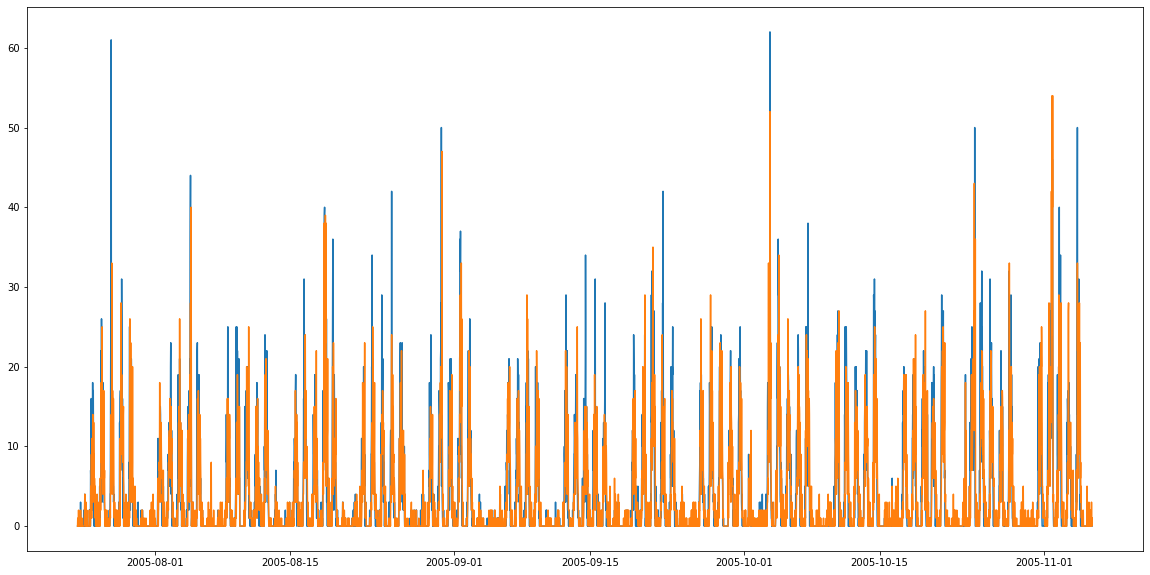

In [3]:
plt.figure(figsize=(20,10))

start = datetime.datetime.strptime("21-06-2014", "%d-%m-%Y")
end = datetime.datetime.strptime("07-07-2014", "%d-%m-%Y")

plt.plot(calTraffic[calTraffic.direction==9].datetime,calTraffic[calTraffic.direction==9].num)
plt.plot(calTraffic[calTraffic.direction==7].datetime,calTraffic[calTraffic.direction==7].num)

plt.show()



In [4]:
#Initiallize columns for events with outcomes and scores of home and away team
events['Outcome'] = 'W'
events['Score 1'] = 0
events['Score 2'] = 0


In [5]:
# Populate the scores with the data from the "W/L score" collumn
for ii in range(len(events)):
    #temp = re.split('  |- ', str(events.at[ii, 'W/L score']))
    temp1 = str(events.at[ii, 'W/L score']).split(' ')
    temp2 = temp1[1].split('-')
    events.at[ii, 'Outcome'] = temp1[0]
    events.at[ii, 'Score 1'] = int(temp2[0])
    events.at[ii, 'Score 2'] = int(temp2[1][:len(temp2[1])-1])


In [6]:
#one hot encode the win loss into 3 categoies (win loss and close game)
events['big_win'] = 0
events['big_loss'] = 0
events['close_game'] = 0

events.loc[list(events[(events['Outcome'] == 'W') & (events['Score 1']-events['Score 2']  > 3)].index), ['big_win']] = 1
events.loc[list(events[(events['Outcome'] == 'L') & (events['Score 1']-events['Score 2']  > 3)].index), ['big_loss']] = 1
events.loc[list(events[events['Score 1']-events['Score 2']  <= 3].index), ['close_game']] = 1
events

,Date,start_event,end_event,Game attendance,Away team,W/L score,Outcome,Score 1,Score 2,big_win,big_loss,close_game
0,2005-04-12,2005-04-12 13:10:00,2005-04-12 16:23:00,55892,San Francisco,W 9-8,W,9,8,0,0,1
1,2005-04-13,2005-04-13 19:10:00,2005-04-13 21:48:00,46514,San Francisco,W 4-1,W,4,1,0,0,1
2,2005-04-15,2005-04-15 19:40:00,2005-04-15 21:48:00,51816,San Diego,W 4-0,W,4,0,1,0,0
3,2005-04-16,2005-04-16 19:10:00,2005-04-16 21:52:00,54704,San Diego,W 8-3,W,8,3,1,0,0
4,2005-04-17,2005-04-17 13:10:00,2005-04-17 15:31:00,53402,San Diego,W 6-0,W,6,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
76,2005-09-25,2005-09-25 13:10:00,2005-09-25 16:06:00,37846,Pittsburgh,W 9-2,W,9,2,1,0,0
77,2005-09-26,2005-09-26 19:10:00,2005-09-26 22:27:00,36397,Pittsburgh,W 9-4,W,9,4,1,0,0
78,2005-09-27,2005-09-27 19:10:00,2005-09-27 21:33:00,42604,Arizona,L 2-0,L,2,0,0,0,1
79,2005-09-28,2005-09-28 19:10:00,2005-09-28 21:58:00,46424,Arizona,L 4-3,L,4,3,0,0,1


In [7]:

ree = events[['big_win','big_loss','close_game']]
np.sum(ree.values,0)


array([16, 16, 49])

In [8]:
# Drop -1 values from the traffic df
neg_indecies = traffic[traffic['count'] == -1].index
traffic =  traffic.drop(neg_indecies ,axis=0)
traffic = traffic.set_index('Datetime')
traffic = traffic.reset_index()


In [9]:
#create cols for the traffic df
traffic['big_win']=0
traffic['big_loss']=0
traffic['close_game']=0
traffic['no_game']=1

#assign each value in the traffic df to one of 4 groups, (Big Win, Big Loss, Close Game, No Game Being Played)
for i,(s,e,w,l,c) in events[['start_event','end_event','big_win','big_loss','close_game']].iterrows():    
    ind=traffic[s<traffic['Datetime']][traffic[s<traffic['Datetime']]['Datetime']<e].index
    traffic.iloc[list(ind[:]),[2,3,4]] = w,l,c
    
traffic['no_game']= traffic['no_game']-traffic['big_win']-traffic['big_loss']-traffic['close_game']


In [10]:
print(traffic['big_win'].sum() )
print(traffic['big_loss'].sum() )
print(traffic['close_game'].sum() )
print(traffic['no_game'].sum() )
print(traffic.shape)


507
506
1607
44877
(47497, 6)


In [11]:
# create a set of training examples, each being the length of one game with the length being constant. 
max_time = (events['end_event']-events['start_event']).max().round('H')
pad_time = datetime.timedelta(hours=1)
traffic.columns


Index(['Datetime', 'count', 'big_win', 'big_loss', 'close_game', 'no_game'], dtype='object')

In [12]:
max_time.seconds/3600


4.0

blah
blah
blah
blah


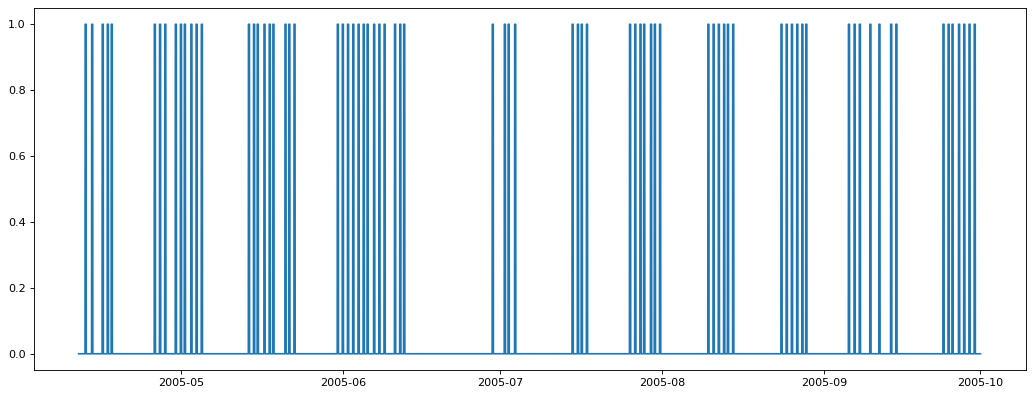

Index(['Datetime', 'count', 'big_win', 'big_loss', 'close_game', 'no_game',
       'game_time'],
      dtype='object')


In [13]:

#create cols to hold boolean for whether you are within 1 hour of a game
traffic['game_time']=0

for i,(s,_) in events[['start_event','end_event']].iterrows():
    s,e = s,s+max_time+pad_time
    ind_n=traffic[traffic['Datetime']>=s][traffic[traffic['Datetime']>=s]['Datetime']<=e].index
    #print(traffic[traffic['Datetime']>s & traffic['Datetime']<e])
    #print(len(ind))
    if len(ind_n) <(max_time.seconds/3600 + 1)*12+1:
        # If there is missing data within the game time throw it out
        #print(len(ind))
        #print(events.values[i][1],events.values[i][1]+max_time+pad_time)
        print('blah')
    else:
        traffic.iloc[list(ind_n[:]),[6]] = 1

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(traffic['Datetime'],traffic['game_time'])
plt.show()
print(traffic.columns)


In [14]:
# Create 6 hour blocks to view traffic right before and right after the game
gt = traffic[['game_time']].values 
    # This will get a vector with ones where there is a game and 0 
    # where there is not. This includes a 60 minute pad time at the end
flips= gt[1:]-gt[:-1]
    # take a discrete derivative to get 0, 1,-1 as the vector (0 no change -1 means end +1 = start)
ind = np.reshape(np.nonzero(flips)[0],[-1,2])
    # get indecies of the vector where there is a flip so that we can extract that data later
print(len(ind))    

# Fill the dataframe with nans where there is a game to train the model
regular_traffic = traffic.copy()
for i,j in ind:
    #regular_traffic = regular_traffic.drop(index=np.arange(i,j))
    regular_traffic.loc[i+1:j, 'count'] = np.nan

s,e = traffic['Datetime'].min(), traffic['Datetime'].max() 
    # get the start and end time to ensure equal spacing of data
total_samples = (e-s).total_seconds()/300 + 1
    #calculate total time then divide by timestep to get tne number of samples we need 
timesteps = [s+datetime.timedelta(minutes=int(5*x)) for x in range(int(total_samples))]
    #create a list of all the times that need to be in the dataset
rt = pd.DataFrame(timesteps, columns =['Datetime'])
    # put them in a DF and name them the same as the Traffic data column with the same data

regular_traffic.reset_index(drop=True,inplace=True) 
    # reset the index and dont include it as a column
regular_traffic.set_index('Datetime',inplace=True)
rt.set_index('Datetime',inplace=True)
rt = rt.join(regular_traffic, on='Datetime')
rt.reset_index(inplace=True)

#print( rt.iloc[:5]) 
#print( rt[['Datetime','count','game_time']].iloc[-5:])
#print(rt.shape,)

rt['game_time']=0

for s,_ in events[['start_event','end_event']].values:  
    s,e = s,s+max_time+pad_time
    ind_gt=rt[rt['Datetime']>=s][rt[rt['Datetime']>=s]['Datetime']<=e].index
    null_num= pd.isnull(rt.iloc[ind_gt,2]).sum()
    #print(null_num)
    if null_num==0:
        rt.iloc[ind_gt.values,[6]]=1
        
    else:
        # this is where count == nan since there is a game
        rt.iloc[ind_gt.values,[2]]=np.nan #set count equal to nan

gt = rt['game_time'].values
flips=gt[1:]-gt[:-1]
ind_rt = np.reshape(np.nonzero(flips)[0],[-1,2])

for i,j in ind_rt:
    #print(i,j)
    #print( pd.isnull( rt[['Datetime','count','game_time']].iloc[i-3:j+4])['count'].sum() )
    #print( rt[['Datetime','count','game_time']].iloc[i-3:j+4]) 
    #print(  rt[['Datetime','count','game_time']].iloc[i-3:j+4]  )  
    pass

77


In [15]:
pd.isnull(rt['game_time']).sum()

0

In [16]:
rt.to_csv('Cleaned_data')

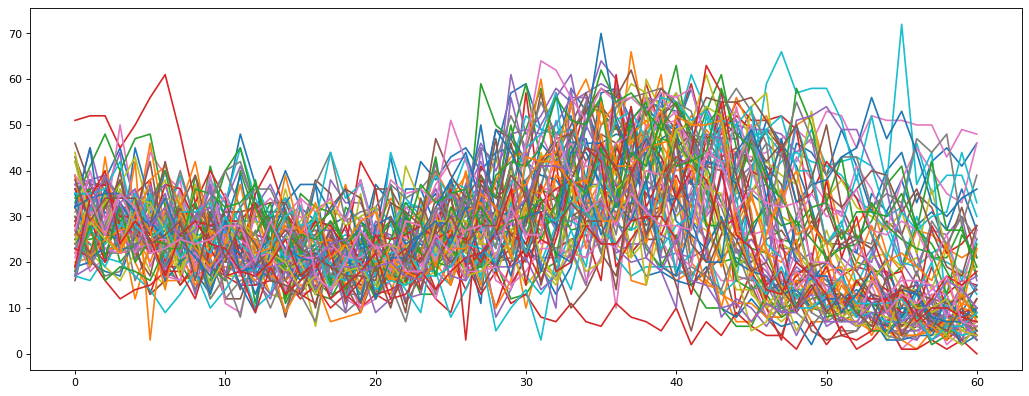

In [17]:
# create list to hold the 77 games 
data = []
#d = []
#plot the 77 games on top of one graph
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(ind.shape[0]):
    #print(traffic[:].values[ind[i][0]:ind[i][1]] )
    #d.append(traffic[:].values[ind[i][0]:ind[i][1]])
    ##traffic['Datetime'].values[ind[i][0]:ind[i][1]]
    data.append(traffic[:].values[ind[i][0]:ind[i][1]])
    plt.plot( np.arange(0,len(traffic['count'].values[ind[i][0]:ind[i][1]])) , traffic['count'].values[ind[i][0]:ind[i][1]])
plt.show()

data = np.array(data)


In [18]:
print(data.shape)
print(np.max(data[:,2,2]))


(77, 61, 7)
1


In [19]:
traffic['count'].values[ind[i][0]:ind[i][1]]

array([39, 34, 26, 35, 32, 22, 23, 25, 24, 25, 28, 28, 20, 29, 22, 34, 17,
       14, 20, 27, 23, 24, 18, 18, 26, 22, 27, 28, 21, 32, 26, 26, 48, 39,
       31, 34, 28, 35, 31, 28, 28, 27, 44, 42, 31, 36, 33, 32, 33, 20, 20,
       17, 24, 19,  9, 13, 11, 14, 17,  7,  6])

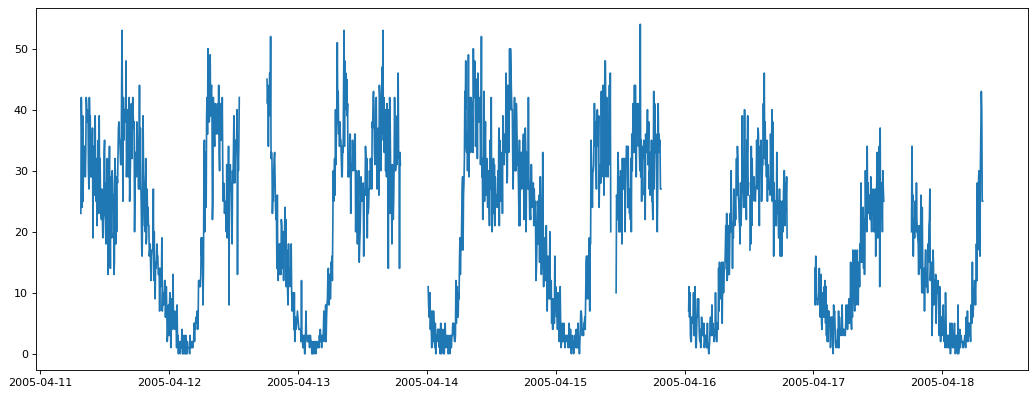

In [20]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(rt['Datetime'][:2016], rt['count'][:2016])

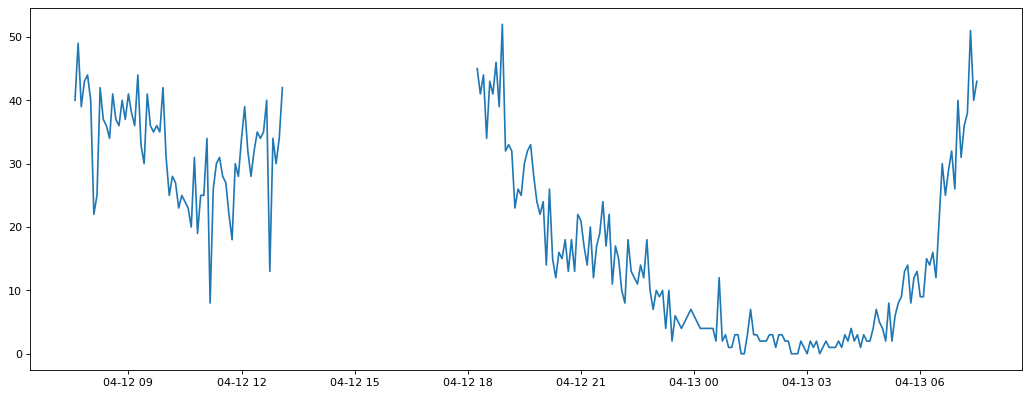

In [21]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(rt['Datetime'][288:288*2], rt['count'][288:288*2])

In [22]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

In [23]:
model = UnobservedComponents(rt['count'], 
                                    level='local level', 
                                    freq_seasonal=[{'period': 331.56666667,
                                                    'harmonics': 1},
                                                   {'period': 292.55882353,
                                                    'harmonics': 1},
                                                  {'period': 290.84795322,
                                                    'harmonics': 1},
                                                   {'period':  274.77900552,
                                                    'harmonics': 1},
                                                  {'period': 143.74277457,
                                                    'harmonics': 1}])


In [24]:
len(data)

77

In [25]:
output_res=model.fit(method='powell', disp=True)

Optimization terminated successfully.
         Current function value: 2.701617
         Iterations: 6
         Function evaluations: 560


In [26]:
output_res.summary()

Dep. Variable:,count,No. Observations:,49735
Model:,local level,Log Likelihood,-134364.935
,+ stochastic freq_seasonal(331.56666667(1)),AIC,268743.869
,+ stochastic freq_seasonal(292.55882353(1)),BIC,268805.569
,+ stochastic freq_seasonal(290.84795322(1)),HQIC,268763.201
,+ stochastic freq_seasonal(274.77900552(1)),,
,+ stochastic freq_seasonal(143.74277457(1)),,
Date:,"Wed, 18 Dec 2019",,
Time:,15:08:51,,
Sample:,0,,
,- 49735,,


/Users/80194465/Documents/Bayes_ML_Final/venv/lib/python3.6/site-packages/statsmodels/tsa/statespace/structural.py:1620: MatplotlibDeprecationWarning: Unrecognized location 'lower_right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  ax.legend(handles, labels, loc=legend_loc)
/Users/80194465/Documents/Bayes_ML_Final/venv/lib/python3.6/site-packages/statsmodels/tsa/statespace/structural.py:1671: MatplotlibDeprecationWarning: Unrecognized location 'lower_right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  ax.legend(loc=legend_loc)


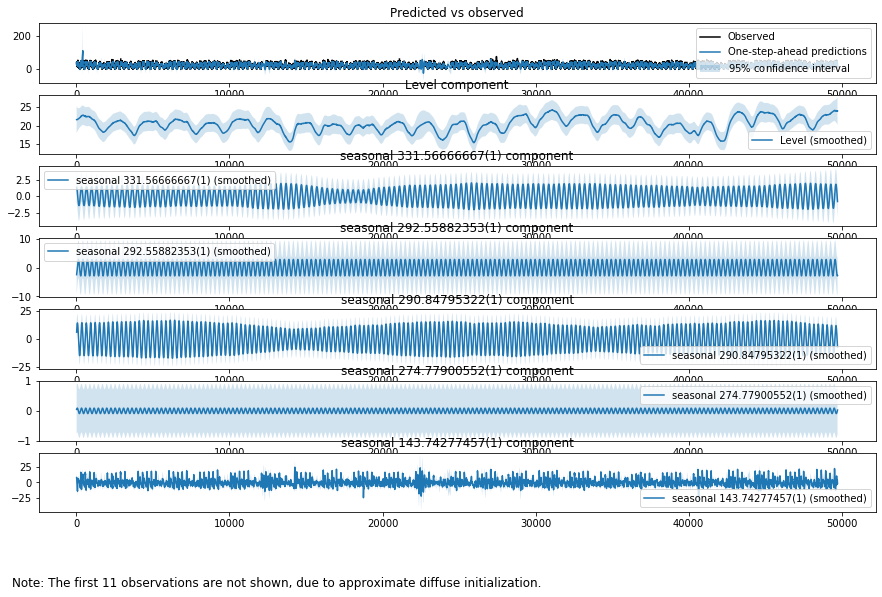

In [27]:
fig = output_res.plot_components(legend_loc='lower_right', figsize=(15,9))

In [28]:
simulate = output_res.get_prediction(0,len(rt)-1)

In [29]:
mean = simulate.predicted_mean

In [30]:
variance = simulate.var_pred_mean

In [31]:
variance.shape

(49735,)

In [32]:
def event_prob(data, prediction_mean, prediction_var):
    return (data-prediction_mean)

In [33]:
def difference(data, prediction_mean, prediction_var):
    return (data-prediction_mean)**2

In [34]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 1       # sample rate, Hz
cutoff = 1/10  # desired cutoff frequency of the filter, Hz

In [35]:
event_probs = []
differences = []

for i in range(len(data)):
        event_probs.append(event_prob(butter_lowpass_filter(data[i][1:,1].astype(np.float), cutoff, fs, order), mean[ind_rt[i,0]+1:ind_rt[i,1]].values, variance[ind_rt[i,0]+1:ind_rt[i,1]]))
        event_probs[len(event_probs)-1] = event_probs[len(event_probs)-1][30:]
        event_probs[len(event_probs)-1] = event_probs[len(event_probs)-1] - min(event_probs[len(event_probs)-1]) 
        event_probs[len(event_probs)-1] = event_probs[len(event_probs)-1]/np.sum(event_probs[len(event_probs)-1])
        
        #differences.append(difference(butter_lowpass_filter(i[:,1].astype(np.float), cutoff, fs, order), mean[rt['Datetime'].isin(i[:,0].tolist())].values, variance[rt['Datetime'].isin(i[:,0].tolist())]))
        #differences[len(event_probs)-1] = differences[len(event_probs)-1][30:]
        #differences[len(event_probs)-1] = differences[len(event_probs)-1]/np.sum(differences[len(event_probs)-1])
        
        

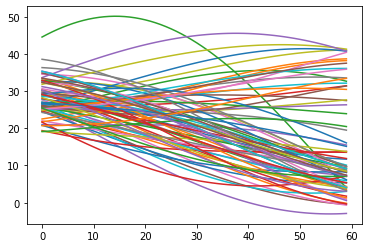

In [36]:
for i in range(1,ind_rt.shape[0]):
    plt.plot(np.arange(60), mean[ind_rt[i,0]+1:ind_rt[i,1]])
plt.show()

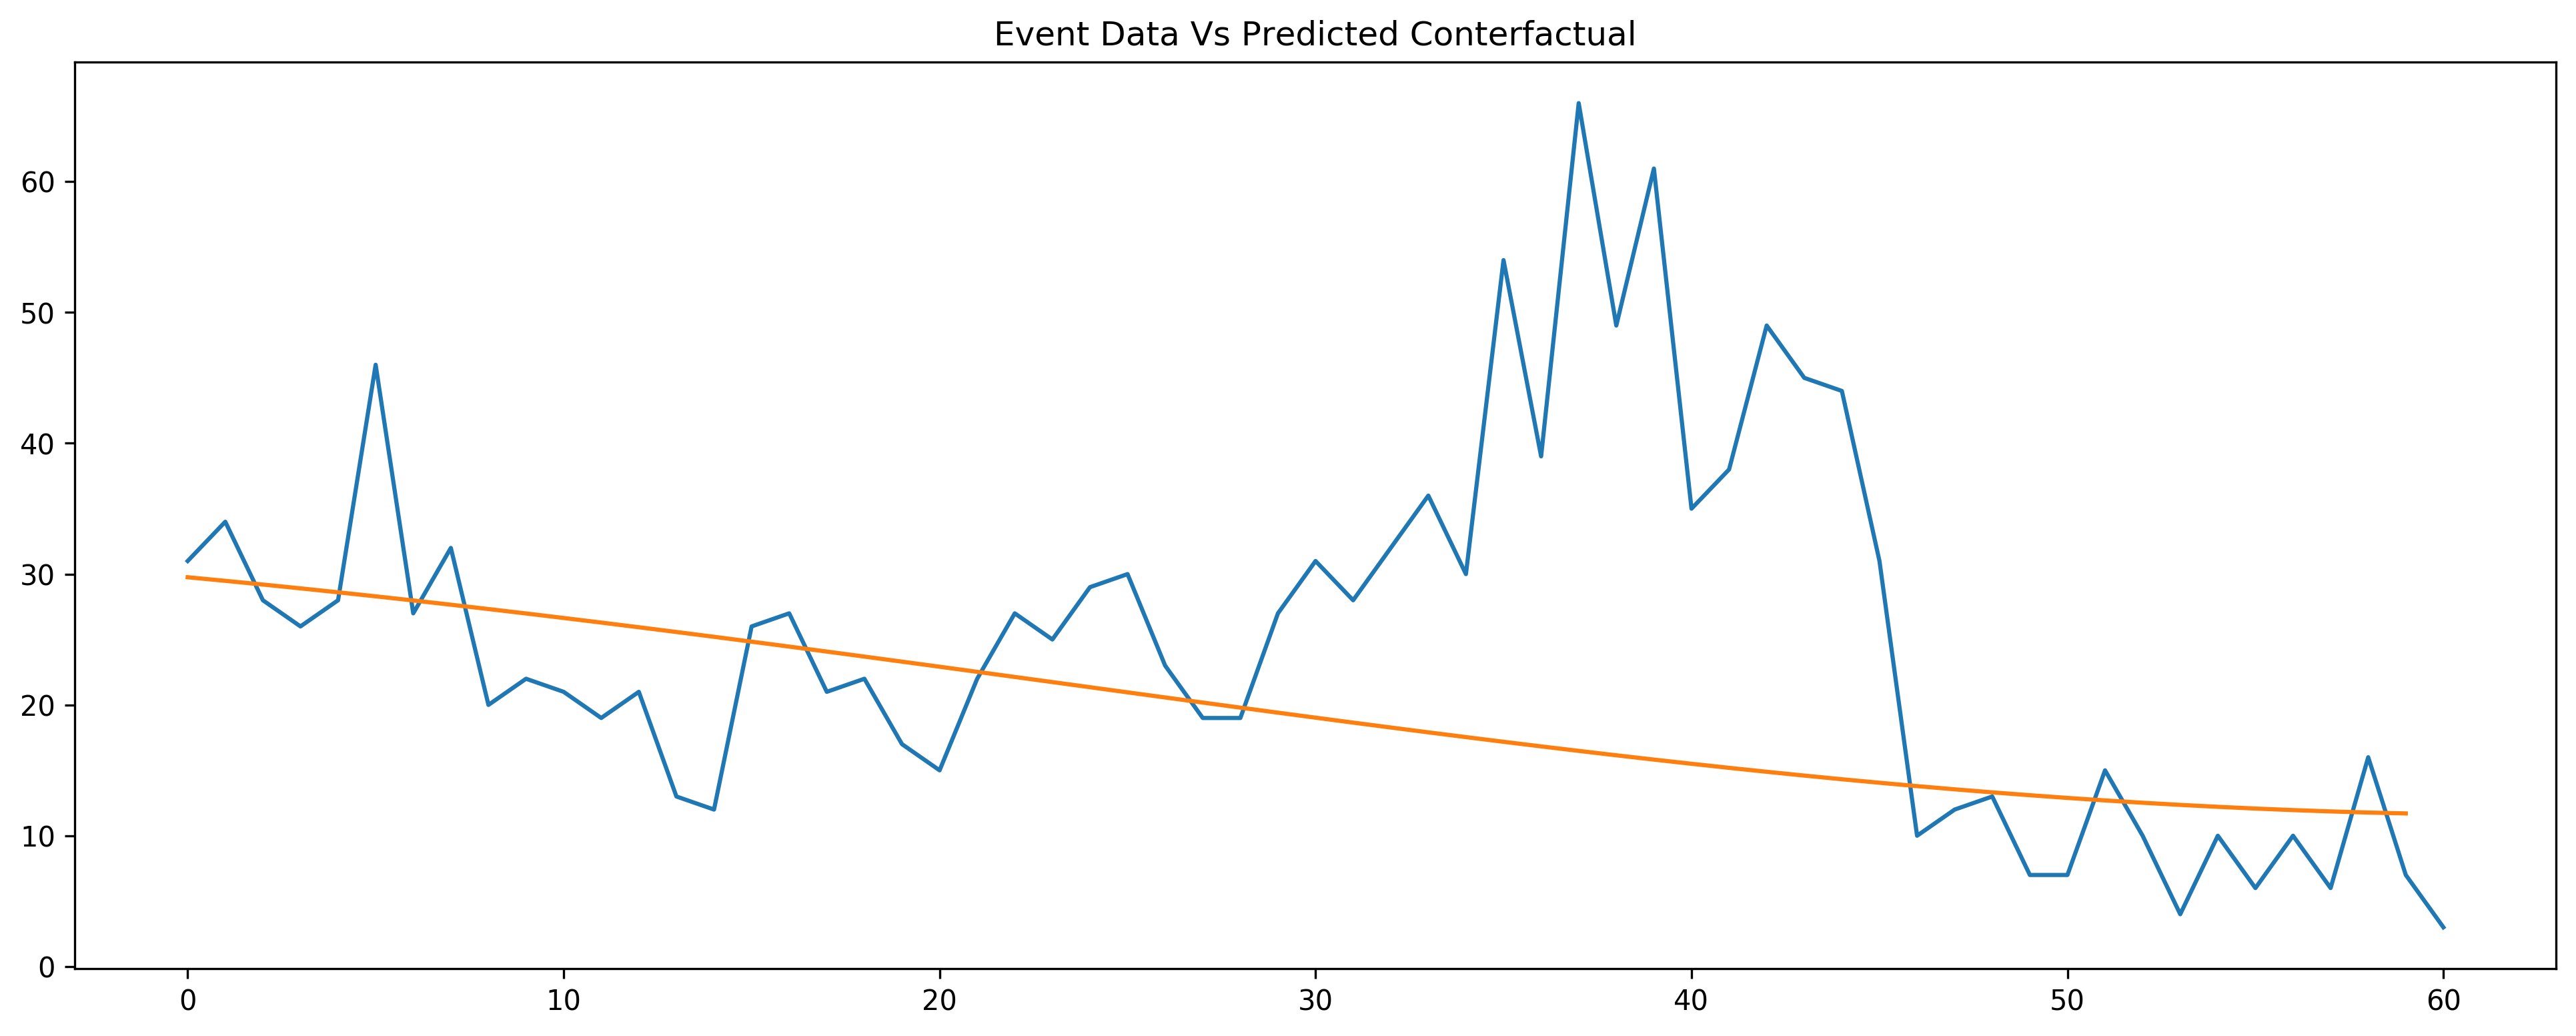

In [37]:
i=1
plt.figure(figsize=(16, 6), dpi=300, facecolor='w', edgecolor='k')
plt.title('Event Data Vs Predicted Conterfactual')
plt.plot( np.arange(0,len(traffic['count'].values[ind[i][0]:ind[i][1]])) , traffic['count'].values[ind[i][0]:ind[i][1]])
plt.plot(np.arange(60), mean[ind_rt[i,0]+1:ind_rt[i,1]])


No handles with labels found to put in legend.


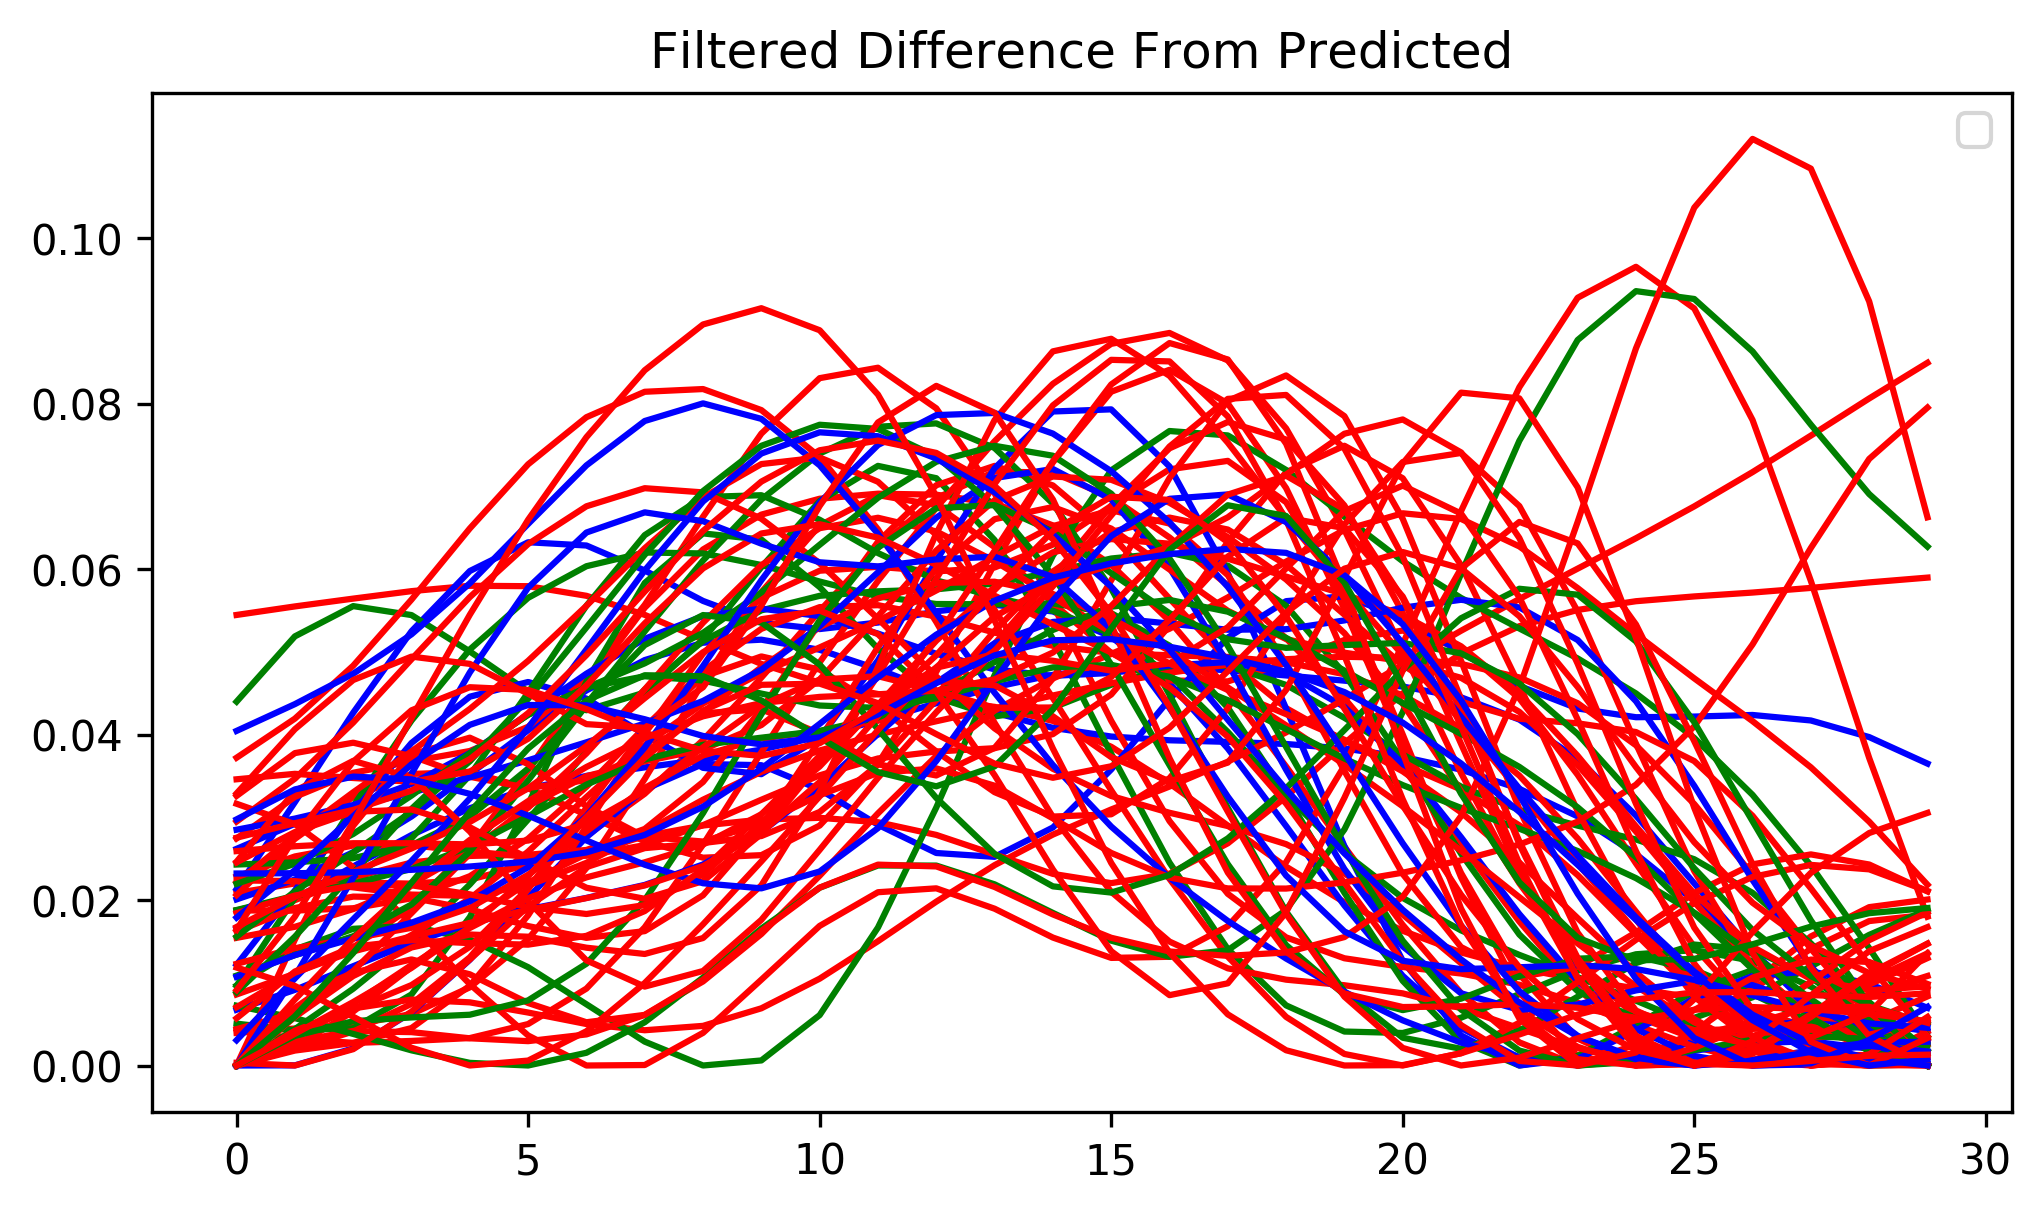

In [38]:
# plot all the various 

fig, ax = plt.subplots(figsize=(8, 4.5),dpi=300)
plt.title("Filtered Difference From Predicted")

for i in range(len(event_probs)):
    if np.any(data[i][:,2] == 1):
        pass
        ax.plot(event_probs[i], color='blue')
    elif np.any(data[i][:,3] == 1):
        pass
        ax.plot(event_probs[i], color='green')
    elif np.any(data[i][:,4] == 1):
        #pass
        ax.plot(event_probs[i],color='red')

    else:
        pass
plt.legend()
plt.savefig('./FilteredDifferenceFromPredicted.png')
plt.show()

       

<Figure size 1200x720 with 0 Axes>

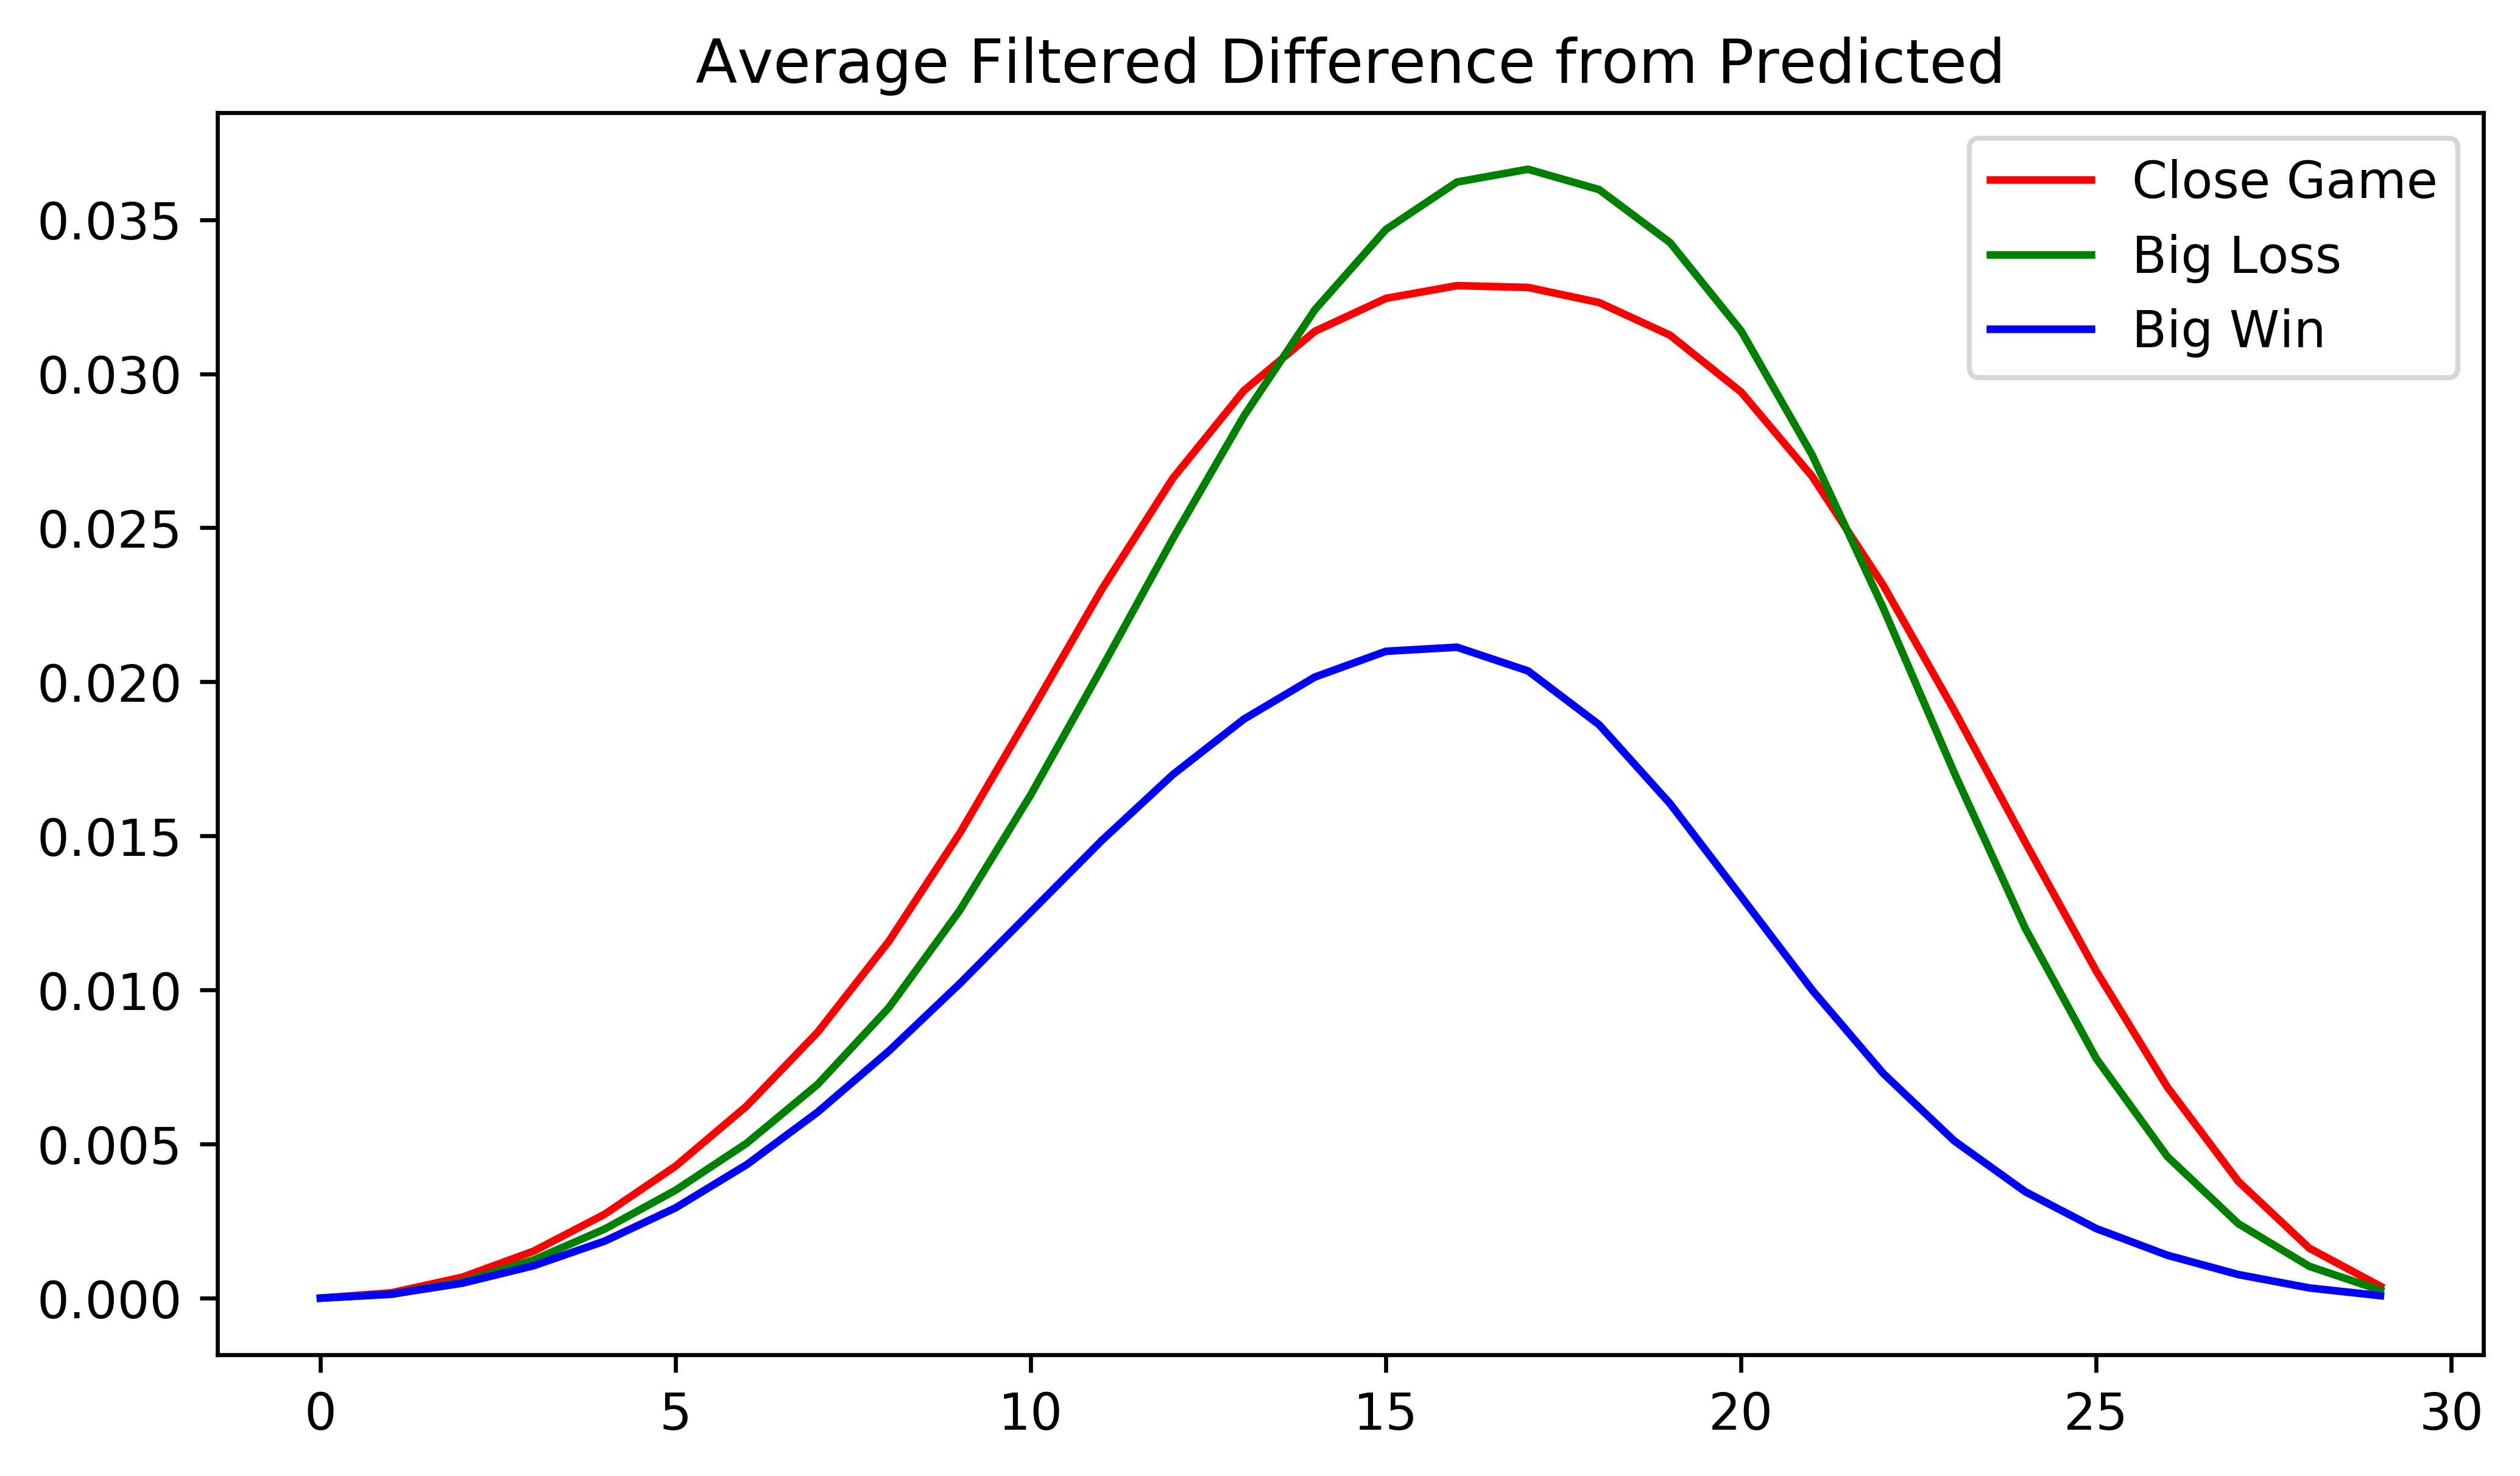

In [49]:
plt.figure(figsize=(15, 9), dpi=80, facecolor='w', edgecolor='k')
r,g,b=[],[],[]
for i in range(len(event_probs)):
    if np.any(data[i][:,2] == 1):
        #pass
        #plt.plot([ sum(event_probs[i][:x]) for x in range(len(event_probs[i]))], color='blue')
        b.append([ sum(event_probs[i][:x]) for x in range(len(event_probs[i]))])
        
    elif np.any(data[i][:,3] == 1):
        pass
        #plt.plot([ sum(event_probs[i][:x]) for x in range(len(event_probs[i]))], color='green')
        g.append([ sum(event_probs[i][:x]) for x in range(len(event_probs[i]))])

    elif np.any(data[i][:,4] == 1):
        pass
        #plt.plot([ sum(event_probs[i][:x]) for x in range(len(event_probs[i]))],color='red')
        r.append([ sum(event_probs[i][:x]) for x in range(len(event_probs[i]))])
    else:
        pass



lab=[]
for i,j in ind_rt:
    lab.append( rt[['big_win',  'big_loss',  'close_game' ]].iloc[i:j].sum(0).values ) 
    pass

lab=np.array(lab)
l= np.zeros(lab.shape)
l[lab!=0]=1
labels = l

points = np.array(data)[:,:,1].astype(np.float)
ep = np.array(event_probs).astype(np.float)

# these next ones will have shape [77] 
# Generate all the features you want here
ep_mean = np.sum(ep* np.tile(np.arange(1,31),(77,1)), axis =1)/np.sum(ep, axis=1)
ep_var =  np.sum(ep*(np.tile(np.atleast_2d(ep_mean).T, (1,30))-np.tile(np.arange(1,31),(77,1)))**2, axis =1)/np.sum(ep, axis=1)
ep_skewness = np.sum(ep*(np.tile(np.atleast_2d(ep_mean).T, (1,30))-np.tile(np.arange(1,31),(77,1)))**3, axis =1)/(np.sum(ep, axis=1)*ep_var**1.5)

feat =np.array( [ ep_mean,ep_var,ep_skewness,]).T

fig, ax = plt.subplots(figsize=(8, 4.5),dpi=600)
plt.title("Average Filtered Difference from Predicted")
ax.plot(np.var(r,0),color='red', label="Close Game")
ax.plot(np.var(g,0),color='green',label="Big Loss")
ax.plot(np.var(b,0),color='blue',label="Big Win")
ax.legend()
plt.show()

#                        b          g               r
#['Datetime', 'count', 'big_win', 'big_loss', 'close_game', 'no_game', 'game_time']


In [50]:
# Show the average properties of each group
d = {
    'Index':['Big_Win','Big_Loss','Close_game'],
    'Weighted_Mean':    [np.mean(ep_mean[labels[:,0]==1]),np.mean(ep_mean[labels[:,1]==1]),np.mean(ep_mean[labels[:,2]==1])],
    'Weighted_Var':     [np.mean(ep_var[labels[:,0]==1]),np.mean(ep_var[labels[:,1]==1]),np.mean(ep_var[labels[:,2]==1])],
    'Weighted_Skewness':[np.mean(ep_skewness[labels[:,0]==1]),np.mean(ep_skewness[labels[:,1]==1]),np.mean(ep_skewness[labels[:,2]==1])] 
}

pd.DataFrame(d).head()

,Index,Weighted_Mean,Weighted_Var,Weighted_Skewness
0,Big_Win,13.448044,38.476895,-0.072765
1,Big_Loss,14.472528,39.197695,-0.095083
2,Close_game,14.996818,40.025635,0.047528


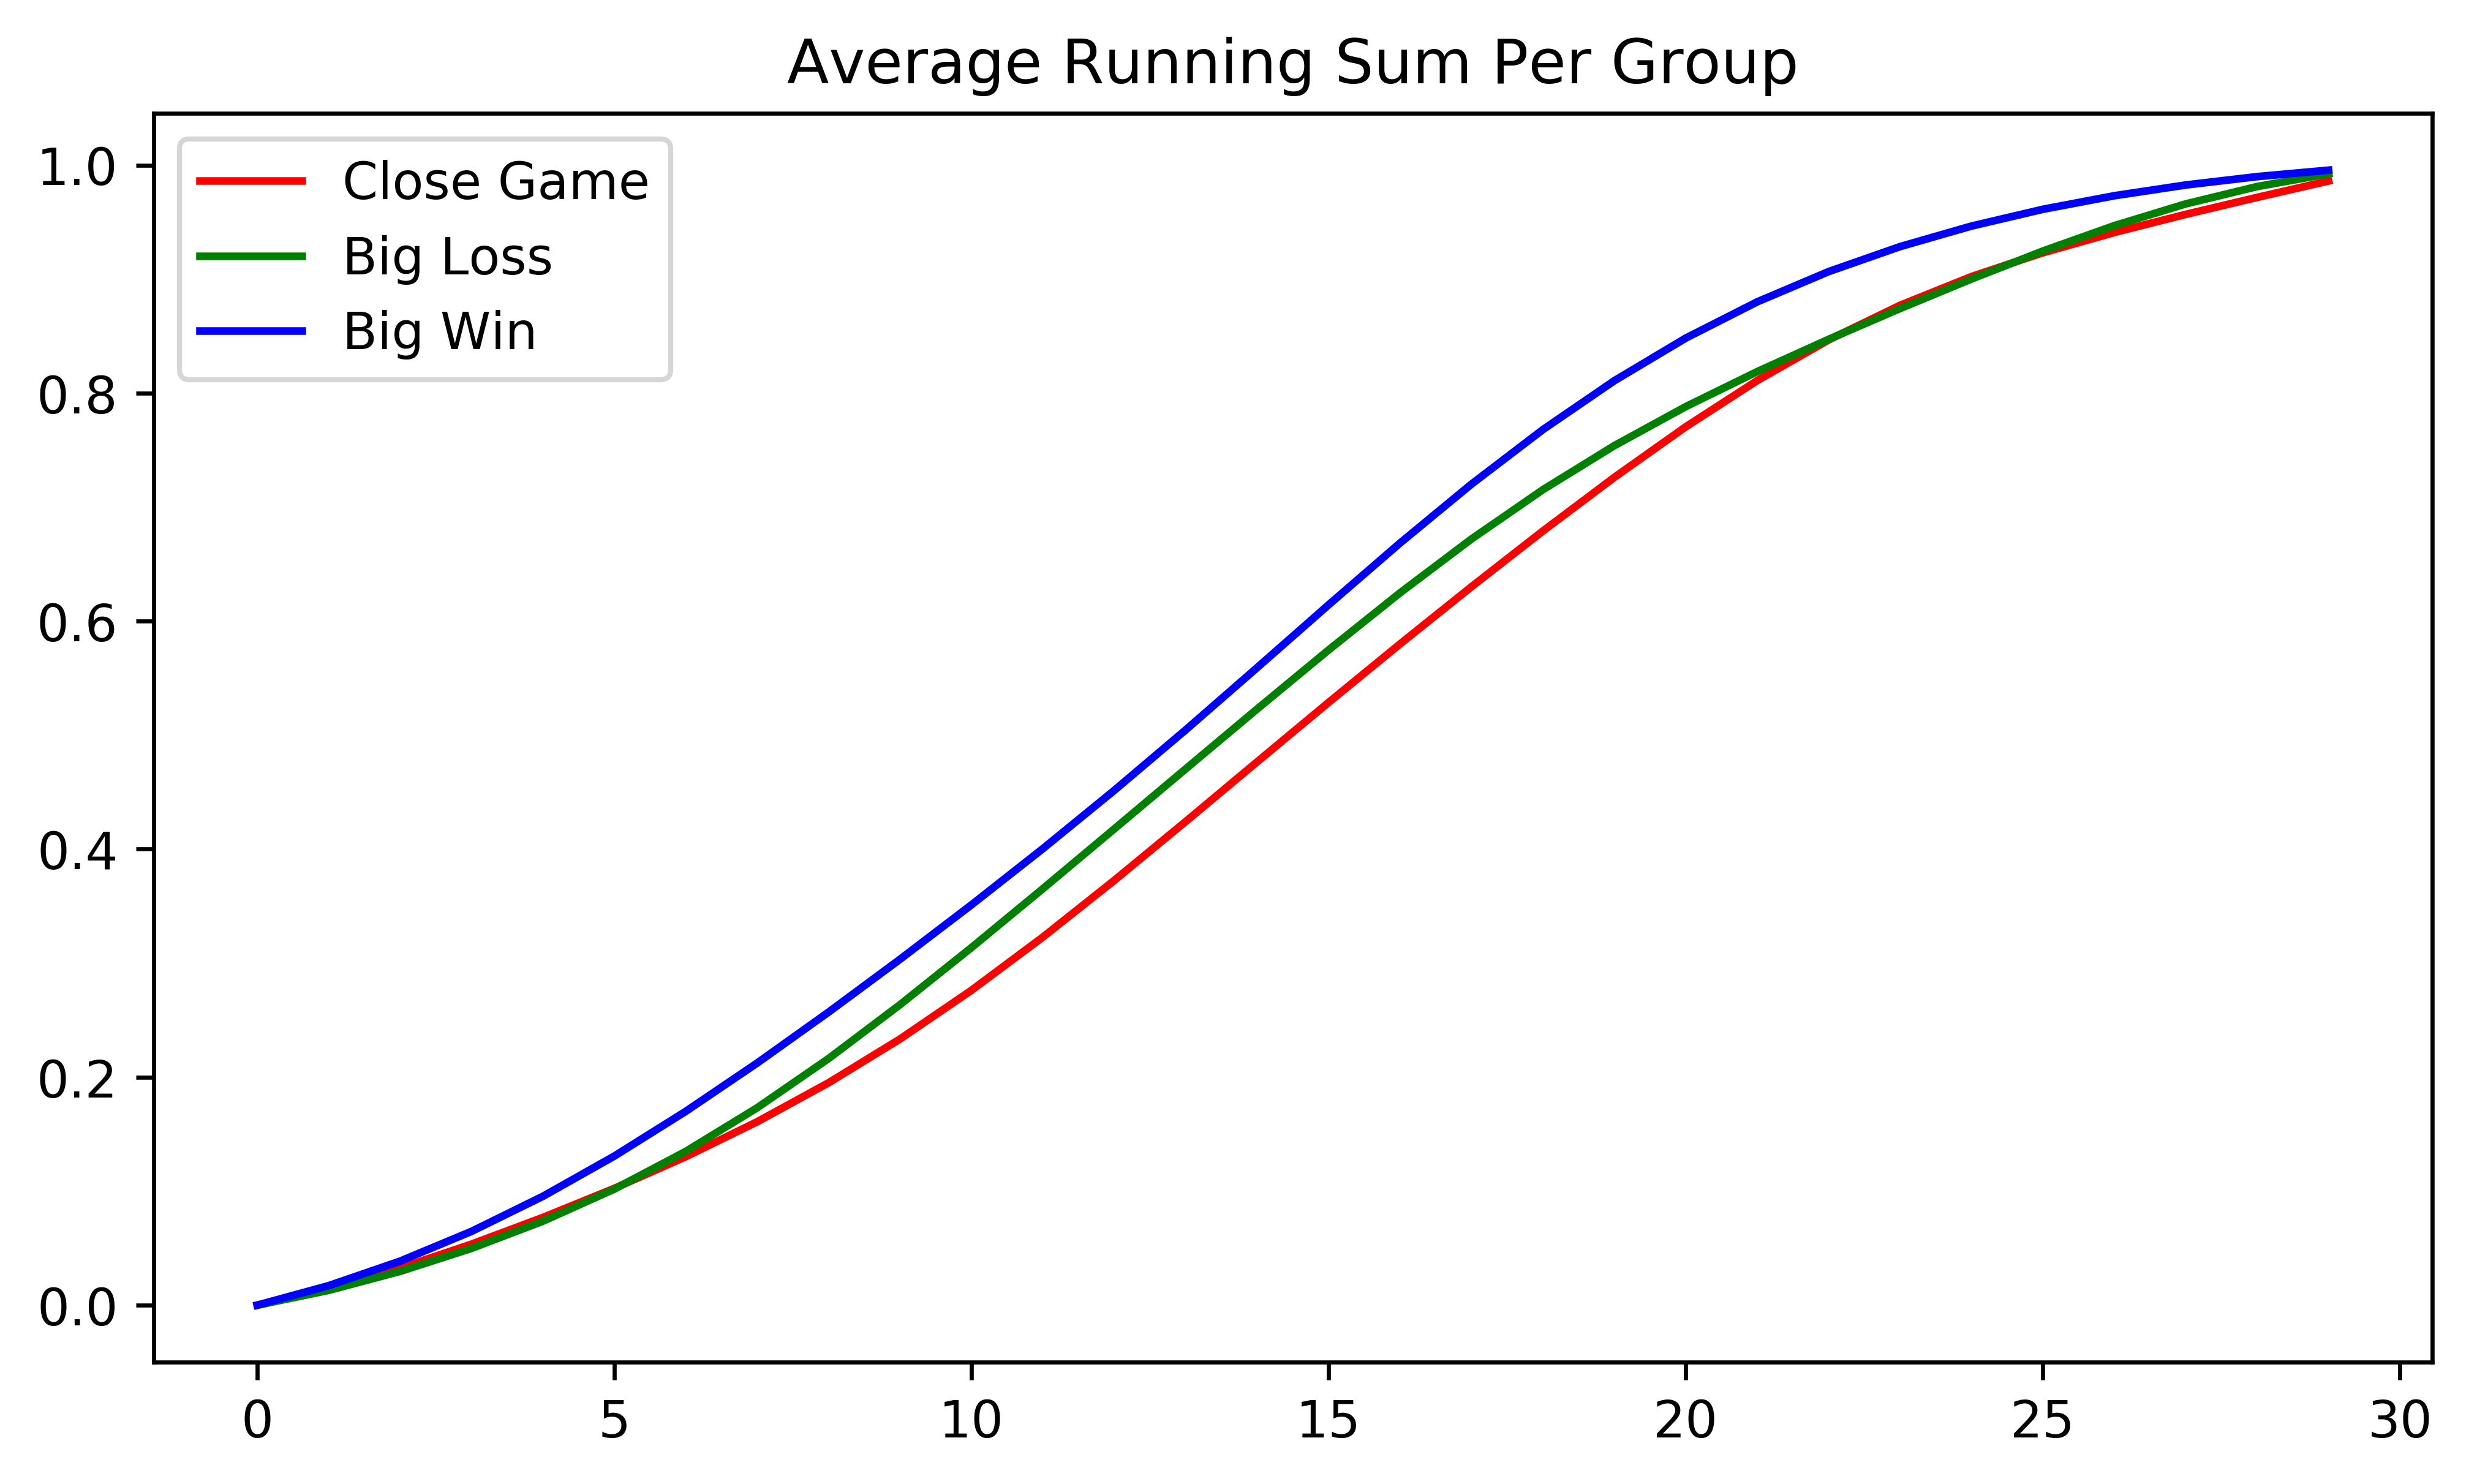

In [51]:
# Show the running sum.
r = np.array(r)
g = np.array(g)
b = np.array(b)

fig, ax = plt.subplots(figsize=(8, 4.5),dpi=600)
plt.title("Average Running Sum Per Group")

ax.plot(np.sum(r,0)/r.shape[0],color='red', label="Close Game",)
ax.plot(np.sum(g,0)/g.shape[0],color='green',label="Big Loss",)
ax.plot(np.sum(b,0)/b.shape[0],color='blue',label="Big Win",)
ax.legend()

plt.show()


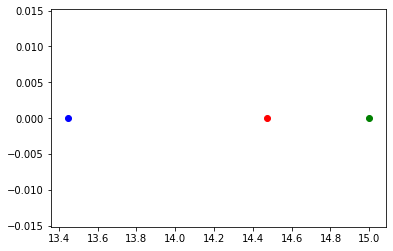

In [63]:
# Show the difference of means

plt.scatter(np.mean(ep_mean[labels[:,0]==1]), 0, color='blue')
plt.scatter(np.mean(ep_mean[labels[:,1]==1]), 0, color='red')
plt.scatter(np.mean(ep_mean[labels[:,2]==1]), 0, color='green')


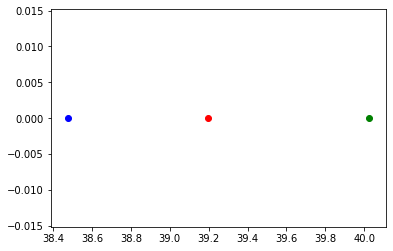

In [64]:
# Show the difference of Variances

plt.scatter(np.mean(ep_var[labels[:,0]==1]), 0, color='blue')
plt.scatter(np.mean(ep_var[labels[:,1]==1]), 0, color='red')
plt.scatter(np.mean(ep_var[labels[:,2]==1]), 0, color='green')


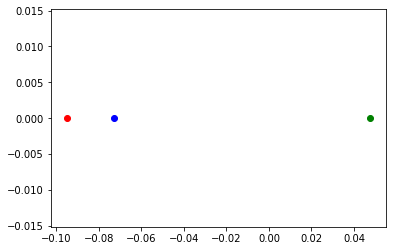

In [65]:
# Show the difference of skewness

plt.scatter(np.mean(ep_skewness[labels[:,0]==1]), 0, color='blue')
plt.scatter(np.mean(ep_skewness[labels[:,1]==1]), 0, color='red')
plt.scatter(np.mean(ep_skewness[labels[:,2]==1]), 0, color='green')

In [68]:
label_squeezed = np.argmax(labels, axis=1)

In [57]:
from sklearn.gaussian_process import GaussianProcessClassifier

def accuracy(t_hat, t_test ):
    acc = np.zeros(t_hat.shape[0])
    acc[t_hat==t_test] = 1 
    #(len(t_hat)- sum(abs(t_hat-t_test))  )/len(t_hat) *100
    return np.sum(acc)/t_hat.shape[0] 

def svm_process(f,l):
    '''
    Following the guide provided in the SVM paper:
    
    Transform data to the format of an SVM package
    Conduct simple scaling on the data
    Consider the RBF kernel 
    Use cross-validation to find the best parameter C and γ
    Use the best parameter C and γ to train the whole training set
    Test
    '''

    # Transform data to the format of an SVM package
    l = np.sum(np.array([l[:,0]*1,l[:,1]*2,l[:,2]*3]).T,1)
    x,t= f,l
    
    # Conduct simple scaling on the data
    x = (x/x.max(axis=0)) #normalize 
    x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.1,)# random_state=42) 
    x_train, x_val, t_train, t_val   = train_test_split(x_train, t_train, test_size=0.30, ) # 72:8:20 train,val,test
    
    '''
    We ran this model as well to see if it would perform better, but it did not increase accuracy
    gpc = GaussianProcessClassifier(multi_class="one_vs_rest", n_restarts_optimizer= 10).fit(x_train, t_train)
    a = gpc.score(x_test, t_test)
    '''
    
    # c = pentalty parameter
    # gamma = kernel parameters
    # kernel type
    i,j = 20,20
    C_opt= [  2**(x-5)for x in range(i)]
    Gamma_opt= [2**(x-15) for x in range(j)]
    acc = np.zeros((i,j))

    # Consider the RBF kernel and use cross-validation to find the best parameter C and γ
    for ci,vi in enumerate(C_opt):
        for cj,vj in enumerate(Gamma_opt):
            clf = SVC(C=vi, decision_function_shape='ovo', kernel='rbf', gamma=vj)
            clf.fit(x_train, t_train)
            t_hat = clf.predict(x_val)
            a  = accuracy(t_hat, t_val )
            acc[ci,cj] = a 

    # Use the best parameter C and γ to train the whole training set
    c_best,gamma_best = (np.unravel_index(np.argmax(acc),acc.shape))
    clf = SVC(C=C_opt[c_best], kernel='rbf',gamma=Gamma_opt[gamma_best])
    clf.fit(np.concatenate((x_train,x_val)),np.concatenate( (t_train,t_val)))
    
    # Test
    t_hat = clf.predict(x_test)
    
    a = accuracy(t_hat, t_test )
    
    # get confusion matrix if you want it 
    c = metrics.confusion_matrix(t_test, t_hat)
    
    return a#,c


In [58]:
# train the best model a hundred times with random seeds 
# each time and see if the accuracy is above guessing 

model_acc = []

for i in range(20):
    
    a = svm_process(feat,labels)
    model_acc.append(a)
    
print(sum(model_acc)/len(model_acc)) 


0.60625


In [59]:
event_mean = []
event_var = []

for i in range(len(event_probs)):    
    event_mean.append(np.sum(event_probs[i]*np.arange(len(event_probs[i])))/np.sum(event_probs[i]))
    event_var.append(np.sqrt(np.sum(event_probs[i]*(np.arange(len(event_probs[i]))-event_mean[i])**2)/np.sum(event_probs[i])))

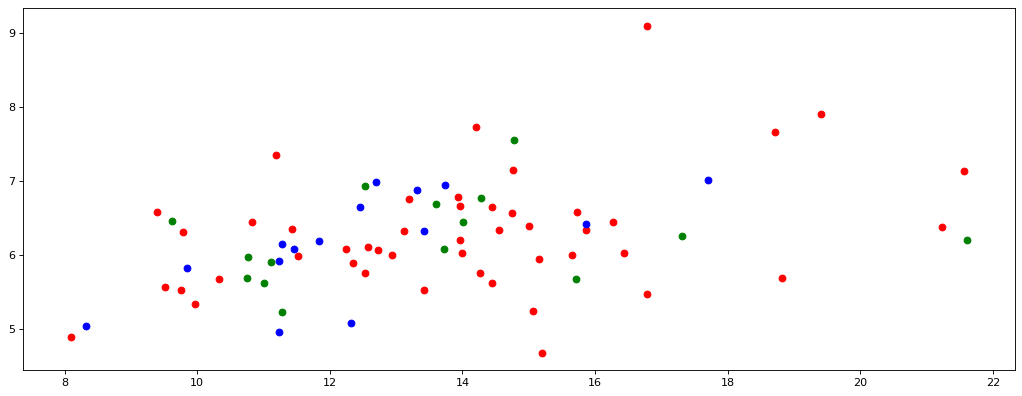

In [60]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

big_win_mean = 0 
big_win_var = 0

big_win_mean = 0
big_win_var = 0

big_win_mean = 0
big_win_var = 0

for i in range(len(event_probs)):
    if np.any(data[i][:,2] == 1):
        plt.scatter(event_mean[i], event_var[i], color='blue') #big win
        
    elif np.any(data[i][:,3] == 1):
        plt.scatter(event_mean[i], event_var[i], color='green') #big loss
    else:
        plt.scatter(event_mean[i], event_var[i], color='red') #close game
        pass